# Benchmarks

These benchmarks seek to establish the performance of tablite as a user sees it.

Overview

**Input/Output:**

- Save / Load .tpz format
- Save tables to various formats
- Import data from various formats

**Various column functions:**

- Setitem / getitem
- iter
- equal, not equal
- copy
- t += t
- t *= t
- contains
- remove all
- replace
- index
- unique
- histogram
- statistics
- count


**Various table functions**

- **base**
  - Setitem / getitem
  - iter / rows
  - equal, not equal
  - load
  - save
  - copy
  - stack
  - types
  - display_dict
  - show
  - to_dict
  - as_json_serializable
  - index
- **core**
  - expression
  - filter
  - sort_index
  - reindex
  - drop_duplicates
  - sort
  - is_sorted
  - any
  - all
  - drop 
  - replace
  - groupby
  - pivot
  - joins
  - lookup
  - replace missing values
  - transpose
  - pivot_transpose
  - diff






In [1]:
from tablite import Table
from tablite.datasets import synthetic_order_data
import psutil, os, gc
import tempfile
from pathlib import Path
from time import perf_counter, time
from tablite.config import Config

### Create tables from synthetic data.

In [2]:
process = psutil.Process(os.getpid())

# The last tables are too big for RAM (~24Gb), so I create subtables of 1M rows and append them.
t = synthetic_order_data(Config.PAGE_SIZE)
real, flat = t.nbytes()
print(f"Table {len(t):,} rows is {real/1e6:,.0f} Mb on disk")

tables = [t]  # 1M rows.

last = 1
t2 = t.copy()
for i in [2,5,10,50,100]:
    t2 = t2.copy()
    for _ in range(i-last):
        t2 += synthetic_order_data(Config.PAGE_SIZE)  # these are all unique
    last = i
    real, flat = t2.nbytes()
    tables.append(t2)
    print(f"Table {len(t2):,} rows is {real/1e6:,.0f} Mb on disk")


Table 1,000,000 rows is 240 Mb on disk
Table 2,000,000 rows is 480 Mb on disk
Table 5,000,000 rows is 1,200 Mb on disk
Table 10,000,000 rows is 2,400 Mb on disk
Table 50,000,000 rows is 12,000 Mb on disk
Table 100,000,000 rows is 24,000 Mb on disk


The values in the tables above are all unique!

In [3]:
tables[-1]

~,#,1,2,3,4,5,6,7,8,9,10,11
0,1,1079926602902,2021-10-25T00:00:00,50676,0,22601,C4-2,UFT,21°,,0.5293805718828299,24.88623347325216
1,2,54327796673,2021-09-05T00:00:00,50926,1,5138,C5-1,PJJ,6°,XYZ,0.3172481517567028,12.08809019382787
2,3,1371151075893,2021-09-05T00:00:00,50903,1,4088,C5-4,CFZ,None,XYZ,1.6077852584113865,4.826606198591954
3,4,1213334662745,2021-10-24T00:00:00,50844,1,29894,C2-2,KUU,None,XYZ,1.2299011666688038,2.244490050711462
4,5,1370511499258,2021-10-30T00:00:00,50623,0,17906,C5-4,USK,None,ABC,0.6522462280897741,5.348279367472272
5,6,2260884629103,2021-11-21T00:00:00,50891,1,11088,C3-4,XQO,0°,,2.14612856506421,20.436899279546175
6,7,1544783389658,2021-08-06T00:00:00,50793,1,13158,C2-1,XLK,0°,XYZ,0.1134401497695328,6.327913859721181
...,...,...,...,...,...,...,...,...,...,...,...,...
"99,999,993",999994,1627489453824,2021-11-14T00:00:00,50273,0,11321,C3-3,GTR,None,,2.34952984429615,8.457874359613998
"99,999,994",999995,638276767240,2021-07-31T00:00:00,50047,1,27487,C2-3,SUS,None,XYZ,1.251194412058548,18.336733533793645


### Save / Load .tpz format

Without compression (fastest)

In [4]:
tmp = Path(tempfile.gettempdir()) / "junk"
tmp.mkdir(exist_ok=True)

save_load_results = Table()
save_load_results.add_columns('rows', 'save (sec)', 'load (sec)')
for t in tables:
    fn = tmp / f'{len(t)}.tpz'
    start = perf_counter()
    t.save(fn)
    end = perf_counter()
    save = round(end-start,3)
    assert fn.exists()
    print(f"saving {len(t):,} rows ({fn.stat().st_size/1e6:,.0f} Mb) took {end-start:,} seconds")
    
    start = perf_counter()
    t2 = Table.load(fn)
    end = perf_counter()
    load = round(end-start,3)
    print(f"loading {len(t2):,} tows took {end-start:,} seconds")
    del t2
    fn.unlink()
    save_load_results.add_rows(len(t), save, load)

saving 1,000,000 rows (240 Mb) took 0.3733541999999943 seconds


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 26.60it/s]


loading 1,000,000 tows took 0.4729399000000285 seconds
saving 2,000,000 rows (480 Mb) took 0.8157509000000118 seconds


importing '2000000.tpz' file: 100%|██████████| 24/24 [00:00<00:00, 25.39it/s]


loading 2,000,000 tows took 0.9655413000000408 seconds
saving 5,000,000 rows (1,200 Mb) took 2.079202199999827 seconds


importing '5000000.tpz' file: 100%|██████████| 60/60 [00:02<00:00, 23.98it/s]


loading 5,000,000 tows took 2.5215765000000374 seconds
saving 10,000,000 rows (2,400 Mb) took 8.23240439999995 seconds


importing '10000000.tpz' file: 100%|██████████| 120/120 [00:10<00:00, 11.76it/s]


loading 10,000,000 tows took 10.247176000000081 seconds
saving 50,000,000 rows (12,000 Mb) took 41.14490069999988 seconds


importing '50000000.tpz' file: 100%|██████████| 600/600 [01:45<00:00,  5.70it/s]


loading 50,000,000 tows took 105.41181819999997 seconds
saving 100,000,000 rows (24,000 Mb) took 62.514134600000034 seconds


importing '100000000.tpz' file: 100%|██████████| 1200/1200 [03:30<00:00,  5.70it/s]


loading 100,000,000 tows took 210.60625939999977 seconds


In [5]:
r = save_load_results
r['save r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['save (sec)']) ]
r['load r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['load (sec)'])]
save_load_results

#,rows,save (sec),load (sec),save r/sec,load r/sec
0,1000000,0.373,0.473,2680965,2114164
1,2000000,0.816,0.966,2450980,2070393
2,5000000,2.079,2.522,2405002,1982553
3,10000000,8.232,10.247,1214771,975895
4,50000000,41.145,105.412,1215214,474329
5,100000000,62.514,210.606,1599641,474820


With various compression options

In [6]:
tmp = Path(tempfile.gettempdir()) / "junk"
tmp.mkdir(exist_ok=True)

t = tables[0]  # 1 m rows

import zipfile  # https://docs.python.org/3/library/zipfile.html#zipfile.ZipFile
methods = [(None, zipfile.ZIP_STORED, "zip stored"), (None, zipfile.ZIP_LZMA, "zip lzma")]
methods += [(i, zipfile.ZIP_DEFLATED, "zip deflated") for i in range(0,10)]
methods += [(i, zipfile.ZIP_BZIP2, "zip bzip2") for i in range(1,10)]

load_and_save_results = Table()
load_and_save_results.add_columns('file size (Mb)', 'method', 'write (sec)', 'read (sec)')
for level, method, name in methods:
    fn = tmp / f'{len(t)}.tpz'
    start = perf_counter()  
    t.save(fn, compression_method=method, compression_level=level)
    end = perf_counter()
    write = round(end-start,3)
    assert fn.exists()
    size = int(fn.stat().st_size/1e6)
    print(f"saving {len(t):,} rows ({size} Mb) took {write} secconds with {name}(level={level})")
    
    start = perf_counter()
    t2 = Table.load(fn)
    end = perf_counter()
    read = round(end-start,3)
    print(f"loading {len(t2):,} rows took {end-start:,} seconds")
    
    del t2
    fn.unlink()
    load_and_save_results.add_rows(size, f"{name}(level={level})", write, read)

saving 1,000,000 rows (240 Mb) took 0.501 secconds with zip stored(level=None)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 28.26it/s]


loading 1,000,000 rows took 0.43679130000009536 seconds
saving 1,000,000 rows (29 Mb) took 99.218 secconds with zip lzma(level=None)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s]


loading 1,000,000 rows took 2.922788599999876 seconds
saving 1,000,000 rows (240 Mb) took 1.66 secconds with zip deflated(level=0)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 21.96it/s]


loading 1,000,000 rows took 0.5594937999999274 seconds
saving 1,000,000 rows (48 Mb) took 1.825 secconds with zip deflated(level=1)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 13.31it/s]


loading 1,000,000 rows took 0.9130832999999257 seconds
saving 1,000,000 rows (46 Mb) took 2.271 secconds with zip deflated(level=2)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 14.12it/s]


loading 1,000,000 rows took 0.8643573999997898 seconds
saving 1,000,000 rows (43 Mb) took 3.015 secconds with zip deflated(level=3)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 17.06it/s]


loading 1,000,000 rows took 0.7156291000001147 seconds
saving 1,000,000 rows (43 Mb) took 3.27 secconds with zip deflated(level=4)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 13.43it/s]


loading 1,000,000 rows took 0.9049110999999357 seconds
saving 1,000,000 rows (42 Mb) took 4.627 secconds with zip deflated(level=5)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 15.05it/s]


loading 1,000,000 rows took 0.8081104000002597 seconds
saving 1,000,000 rows (39 Mb) took 9.057 secconds with zip deflated(level=6)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 15.79it/s]


loading 1,000,000 rows took 0.7721261000001505 seconds
saving 1,000,000 rows (39 Mb) took 13.639 secconds with zip deflated(level=7)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 16.05it/s]


loading 1,000,000 rows took 0.7578780999997434 seconds
saving 1,000,000 rows (38 Mb) took 55.605 secconds with zip deflated(level=8)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 16.98it/s]


loading 1,000,000 rows took 0.7176447000001644 seconds
saving 1,000,000 rows (37 Mb) took 117.313 secconds with zip deflated(level=9)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:00<00:00, 16.69it/s]


loading 1,000,000 rows took 0.7334209000000556 seconds
saving 1,000,000 rows (29 Mb) took 14.794 secconds with zip bzip2(level=1)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:04<00:00,  3.00it/s]


loading 1,000,000 rows took 4.01251480000019 seconds
saving 1,000,000 rows (29 Mb) took 16.274 secconds with zip bzip2(level=2)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


loading 1,000,000 rows took 4.193540599999778 seconds
saving 1,000,000 rows (29 Mb) took 17.426 secconds with zip bzip2(level=3)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


loading 1,000,000 rows took 4.190689399999883 seconds
saving 1,000,000 rows (29 Mb) took 17.627 secconds with zip bzip2(level=4)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


loading 1,000,000 rows took 4.852936799999952 seconds
saving 1,000,000 rows (29 Mb) took 18.222 secconds with zip bzip2(level=5)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


loading 1,000,000 rows took 5.134584800000084 seconds
saving 1,000,000 rows (29 Mb) took 19.099 secconds with zip bzip2(level=6)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


loading 1,000,000 rows took 5.196291899999778 seconds
saving 1,000,000 rows (29 Mb) took 18.892 secconds with zip bzip2(level=7)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


loading 1,000,000 rows took 5.476160300000174 seconds
saving 1,000,000 rows (29 Mb) took 19.489 secconds with zip bzip2(level=8)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


loading 1,000,000 rows took 5.540870600000289 seconds
saving 1,000,000 rows (29 Mb) took 19.395 secconds with zip bzip2(level=9)


importing '1000000.tpz' file: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]

loading 1,000,000 rows took 5.485102800000277 seconds


In [7]:
r = load_and_save_results
r.sort({'write (sec)':True})
r['write (rps)'] = [int(1_000_000/b) for b in r['write (sec)']]
r['read (rps)'] = [int(1_000_000/b) for b in r['read (sec)']]

creating sort index: 100%|██████████| 1/1 [00:00<00:00, 199.03it/s]


In [8]:
load_and_save_results[0:20]

#,file size (Mb),method,write (sec),read (sec),write (rps),read (rps)
0,37,zip deflated(level=9),117.313,0.733,8524,1364256
1,29,zip lzma(level=None),99.218,2.923,10078,342114
2,38,zip deflated(level=8),55.605,0.718,17983,1392757
3,29,zip bzip2(level=8),19.489,5.541,51310,180472
4,29,zip bzip2(level=9),19.395,5.485,51559,182315
5,29,zip bzip2(level=6),19.099,5.196,52358,192455
6,29,zip bzip2(level=7),18.892,5.476,52932,182615
7,29,zip bzip2(level=5),18.222,5.135,54878,194741
8,29,zip bzip2(level=4),17.627,4.853,56731,206058
9,29,zip bzip2(level=3),17.426,4.191,57385,238606


**Conclusions**

- Fastest: zip stored with no compression takes handles 

### Save / load tables to / from various formats

The handlers for saving / export are:

- to_sql
- to_json
- to_xls
- to_ods
- to_csv
- to_tsv
- to_text
- to_html
- to_hdf5


In [9]:
n_rows = 10_000_000
L = [t for t in tables if len(t)>=n_rows]
t = L[0]

tmp = Path(tempfile.gettempdir()) / "junk"
tmp.mkdir(exist_ok=True)

In [10]:
tmp = Path(tempfile.gettempdir()) / "junk"
tmp.mkdir(exist_ok=True)

import_export_results = Table()
import_export_results.add_columns('method', 'write (s)', 'read (s)', 'rows', 'size (Mb)', 'config')

In [11]:
def to_sql_benchmark(t, rows=1_000_000):
    t2 = t[:rows]
    write_start = time()
    _ = t2.to_sql(name='1')
    write_end = time()
    write = round(write_end-write_start,3)
    import_export_results.add_rows( t.to_sql.__name__, write, 0, len(t), "" , "" ) 

to_sql_benchmark(t)

In [12]:
def to_json_benchmark(t, rows=1_000_000):
    t2 = t[:rows]
    path = tmp / "1.json"    
    write_start = time()
    bytestr = t2.to_json()
    with path.open('w') as fo:
        fo.write(bytestr)
    write_end = time()
    write = round(write_end-write_start,3)

    read_start = time()
    with path.open('r') as fi:
        _ = Table.from_json(fi.read())  # <-- JSON
    read_end = time()
    read = round(read_end-read_start,3)

    import_export_results.add_rows( t.to_json.__name__, write, read, len(t), int(path.stat().st_size/1e6), "" ) 

to_json_benchmark(t)

In [13]:
def f(import_export_results, t, args):
    rows, c1, c1_kw, c2, c2_kw = args
    t2 = t[:rows]

    call = getattr(t2, c1)
    assert callable(call)

    write_start = time()
    call(**c1_kw)
    write_end = time()
    write = round(write_end-write_start,3)

    for _ in range(10):
        gc.collect()

    read_start = time()
    if callable(c2):
        c2(**c2_kw)
    read_end = time()
    read = round(read_end-read_start,3)

    fn = c2_kw['path']
    assert fn.exists()
    fs = int(fn.stat().st_size/1e6)
    config = {k:v for k,v in c2_kw.items() if k!= 'path'}

    import_export_results.add_rows( c1, write, read, len(t2), fs , str(config))

args = [
    (   100_000, "to_xlsx", {'path': tmp/'1.xlsx'}, Table.from_file, {"path":tmp/'1.xlsx', "sheet":"pyexcel_sheet1"}),
    (   100_000,  "to_ods",  {'path': tmp/'1.ods'}, Table.from_file, {"path":tmp/'1.ods', "sheet":"pyexcel_sheet1"} ),
    ( 1_000_000,  "to_csv",  {'path': tmp/'1.csv'}, Table.from_file, {"path":tmp/'1.csv'}                           ),
    ( 1_000_000,  "to_csv",  {'path': tmp/'1.csv'}, Table.from_file, {"path":tmp/'1.csv', "guess_datatypes":False}),
    (10_000_000,  "to_csv",  {'path': tmp/'1.csv'}, Table.from_file, {"path":tmp/'1.csv', "guess_datatypes":False}),
    ( 1_000_000,  "to_tsv",  {'path': tmp/'1.tsv'}, Table.from_file, {"path":tmp/'1.tsv'}                           ),
    ( 1_000_000, "to_text",  {'path': tmp/'1.txt'}, Table.from_file, {"path":tmp/'1.txt'}                           ),
    ( 1_000_000, "to_html", {'path': tmp/'1.html'}, Table.from_file, {"path":tmp/'1.html'}                          ),
    ( 1_000_000, "to_hdf5", {'path': tmp/'1.hdf5'}, Table.from_file, {"path":tmp/'1.hdf5'}                          )
]

Config.PROCESSING_MODE = Config.FALSE
for arg in args:
    assert len(t)>=arg[0]
    print(arg[1], arg[0])
    f(import_export_results, t, arg)

import shutil
shutil.rmtree(tmp)

to_xlsx 100000
to_ods 100000
to_csv 1000000


100%|██████████| 1000000/1000000 [00:19<00:00, 50799.84it/s]
importing: consolidating '1.csv': 100.00%|██████████| [00:19<00:00]


to_csv 1000000


100%|██████████| 1000000/1000000 [00:18<00:00, 52824.44it/s]
importing: consolidating '1.csv': 100.00%|██████████| [00:10<00:00]


to_csv 10000000


100%|██████████| 10000000/10000000 [03:13<00:00, 51665.55it/s]
importing: consolidating '1.csv': 100.00%|██████████| [02:10<00:00]


to_tsv 1000000


100%|██████████| 1000000/1000000 [00:19<00:00, 52422.74it/s]
importing: consolidating '1.tsv': 100.00%|██████████| [00:19<00:00]


to_text 1000000


100%|██████████| 1000000/1000000 [00:18<00:00, 53139.94it/s]
importing: consolidating '1.txt': 100.00%|██████████| [00:18<00:00]


to_html 1000000


from_html: 100%|██████████| 228959661/228959661 [01:12<00:00, 3175331.85it/s]


to_hdf5 1000000
writing 12,000,000 records to C:\Users\madsenbj\AppData\Local\Temp\junk\1.hdf5... done


In [14]:
r = import_export_results
r['read r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['read (s)']) ]
r['write r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['write (s)'])]

In [15]:
t

~,#,1,2,3,4,5,6,7,8,9,10,11
0,1,1079926602902,2021-10-25T00:00:00,50676,0,22601,C4-2,UFT,21°,,0.5293805718828299,24.88623347325216
1,2,54327796673,2021-09-05T00:00:00,50926,1,5138,C5-1,PJJ,6°,XYZ,0.3172481517567028,12.08809019382787
2,3,1371151075893,2021-09-05T00:00:00,50903,1,4088,C5-4,CFZ,None,XYZ,1.6077852584113865,4.826606198591954
3,4,1213334662745,2021-10-24T00:00:00,50844,1,29894,C2-2,KUU,None,XYZ,1.2299011666688038,2.244490050711462
4,5,1370511499258,2021-10-30T00:00:00,50623,0,17906,C5-4,USK,None,ABC,0.6522462280897741,5.348279367472272
5,6,2260884629103,2021-11-21T00:00:00,50891,1,11088,C3-4,XQO,0°,,2.14612856506421,20.436899279546175
6,7,1544783389658,2021-08-06T00:00:00,50793,1,13158,C2-1,XLK,0°,XYZ,0.1134401497695328,6.327913859721181
...,...,...,...,...,...,...,...,...,...,...,...,...
"9,999,993",999994,2094970914818,2021-10-07T00:00:00,50971,0,21372,C2-1,IZO,21°,XYZ,1.013730336909649,19.62648105695804
"9,999,994",999995,938044111048,2021-12-18T00:00:00,50784,1,19038,C3-4,YRN,6°,,0.8593174729892686,1.6511959571650978


In [16]:
import_export_results

#,method,write (s),read (s),rows,size (Mb),config,read r/sec,write r/sec
0,to_sql,15.664,0,10000000,,,nil,638406
1,to_json,13.393,4.247,10000000,142,,2354603,746658
2,to_xlsx,13.549,24.265,100000,9,{'sheet': 'pyexcel_sheet1'},4121,7380
3,to_ods,72.814,68.393,100000,7,{'sheet': 'pyexcel_sheet1'},1462,1373
4,to_csv,19.69,19.451,1000000,109,{},51411,50787
5,to_csv,18.949,10.494,1000000,109,{'guess_datatypes': False},95292,52773
6,to_csv,193.553,131.011,10000000,1090,{'guess_datatypes': False},76329,51665
7,to_tsv,19.079,19.252,1000000,109,{},51942,52413
8,to_text,18.822,18.687,1000000,109,{},53513,53129
9,to_html,14.703,72.132,1000000,228,{},13863,68013


**Conclusions**

Best:
- to/from JSON wins with 2.3M rps read
- to/from CSV/TSV/TEXT comes 2nd with config `guess_datatypes=False` with ~ 100k rps

Worst:
- to/from ods burst the memory footprint and hence had to be reduced to 100k rows. It also had the slowest read rate with 1450 rps.


# Various column functions

- Setitem / getitem
- iter
- equal, not equal
- copy
- t += t
- t *= t
- contains
- remove all
- replace
- index
- unique
- histogram
- statistics
- count

In [17]:
big_table = tables[-1]

for name in big_table.columns:
    col = big_table[name]
    n = len(col)
    start,stop,step = int(n*0.02), int(n*0.98), int(n/100)
    selection = col[start:stop:step]
    total_time = 0.0
    for v in selection:
        start_time = time()
        v in col
        end_time = time()
        total_time += end_time-start_time
    avg_time = total_time / len(selection)

getitem_results = Table()
getitem_results.add_columns('')
    

# Various table functions

In [18]:
big_table = tables[-1]
n = len(big_table)
start,stop,step = int(0.02*n), int(0.98*n), int(n / 20)  # from 2% to 98% in 20 large steps
start_time = time()
snip = big_table[start:stop:step]
end_time = time()
snip

~,#,1,2,3,4,5,6,7,8,9,10,11
0,1,2072513958640,2021-12-16T00:00:00,50110,1,13942,C1-3,GUS,6°,,2.244221839580203,22.057087210094775
1,1,1494119848789,2021-12-19T00:00:00,50492,1,3406,C1-3,MRA,None,XYZ,0.2813016215128882,19.00940579501286
2,1,279991064168,2021-10-09T00:00:00,50543,1,22788,C3-4,IJB,None,ABC,0.8095463729515255,13.201598709331353
3,1,380655146625,2021-08-26T00:00:00,50419,1,18264,C5-1,AYS,None,ABC,0.7582427217875339,4.068585302608566
4,1,1412321255688,2021-10-13T00:00:00,50697,0,6196,C1-2,DGI,None,XYZ,0.7480253948706265,1.081276419298878
5,1,2071834707116,2021-10-06T00:00:00,50418,1,3712,C3-4,CVZ,21°,ABC,1.018398240011883,8.649293839323905
6,1,555140717186,2021-10-21T00:00:00,50893,0,13819,C5-4,FTX,None,XYZ,0.45148108213877125,1.5506090487252329
7,1,2178595743140,2021-09-28T00:00:00,50992,1,18719,C2-3,NTW,6°,ABC,1.6856785087386448,17.583678183859558
8,1,1935214940191,2021-09-07T00:00:00,50507,0,9366,C3-3,HUU,6°,,0.8078940522070547,21.274450459605937
9,1,2043153811304,2021-11-01T00:00:00,50451,0,20314,C3-3,XWU,None,ABC,2.4267161306291567,18.591696291051836


In [19]:
print(f"reading {len(big_table):,} rows to find {len(snip):,} rows took {round(end_time-start_time,3)} sec")

reading 100,000,000 rows to find 20 rows took 4.229 sec


In [20]:
start_time = time()
snip = big_table['1', '3', '6', '9']
end_time = time()
snip

#,1,3,6,9
0,1079926602902,50676,C4-2,
1,54327796673,50926,C5-1,XYZ
2,1371151075893,50903,C5-4,XYZ
3,1213334662745,50844,C2-2,XYZ
4,1370511499258,50623,C5-4,ABC
5,2260884629103,50891,C3-4,
6,1544783389658,50793,C2-1,XYZ
...,...,...,...,...
"99,999,993",1627489453824,50273,C3-3,
"99,999,994",638276767240,50047,C2-3,XYZ


In [21]:
print(f"selecting 4 columns from {len(big_table.columns)} columns on {len(big_table):,} rows took {round(end_time-start_time,3)} sec")

selecting 4 columns from 12 columns on 100,000,000 rows took 0.001 sec


In [24]:
getitem_results = Table()
getitem_results.add_columns( 'n columns', 'time (s)')

columns = ['1']
for column in list(big_table.columns):
    columns.append(column)
    snip = big_table.__getitem__(*columns, slice(500_000,1_500_000))
    start_time = perf_counter()
    counts = 0
    for row in snip.rows:
        counts += 1
    end_time = perf_counter()
    getitem_results.add_rows( len(columns), round(end_time-start_time,3))

getitem_results

#,n columns,time (s)
0,2,1.508
1,3,1.511
2,4,2.587
3,5,3.243
4,6,3.974
5,7,4.587
6,8,5.598
7,9,6.437
8,10,7.368
9,11,8.391


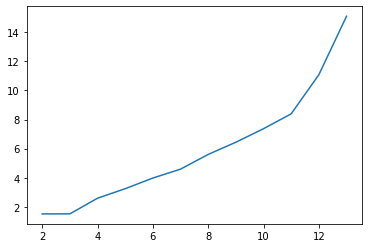

In [26]:
import matplotlib.pyplot as plt
plt.plot(getitem_results['n columns'], getitem_results['time (s)'])
plt.show()
